In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import gc
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from torch.utils.data import DataLoader, Dataset
import sys

# Set CS182-Final-Project as the project root
# Since the notebook is in experiments/v3/, we need to go up 2 levels
notebook_path = os.path.abspath('')
project_root = os.path.dirname(os.path.dirname(notebook_path))  # Go up 2 levels
os.chdir(project_root)

print("Setup complete. Current directory:", os.getcwd())
print("Project root set to:", project_root)

/home/richard/miniconda3/envs/esm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Current directory: /home/richard/projects/CS182-Final-Project
Project root set to: /home/richard/projects/CS182-Final-Project


In [3]:
# Inspect the data structure in the pickle files
import pickle

print("Inspecting training data structure...")
with open('data/full_dataset/pair_embeddings/train_data_with_mae_embeddings_20250530-151013.pkl', 'rb') as f:
    train_data_mae = pickle.load(f)

print(f"Type of loaded data: {type(train_data_mae)}")
print(f"Keys/attributes available: {list(train_data_mae.keys()) if hasattr(train_data_mae, 'keys') else 'No keys (not a dict)'}")

if hasattr(train_data_mae, 'columns'):
    print(f"DataFrame columns: {list(train_data_mae.columns)}")
    print(f"DataFrame shape: {train_data_mae.shape}")
    print(f"DataFrame head:")
    print(train_data_mae.head())

if isinstance(train_data_mae, dict):
    for key, value in train_data_mae.items():
        print(f"Key '{key}': type={type(value)}, shape={getattr(value, 'shape', 'no shape')}")

print("\n" + "="*50)
print("Inspecting validation data structure...")
with open('data/full_dataset/pair_embeddings/val_data_with_mae_embeddings_20250530-151013.pkl', 'rb') as f:
    val_data_mae = pickle.load(f)

print(f"Type of loaded data: {type(val_data_mae)}")
print(f"Keys/attributes available: {list(val_data_mae.keys()) if hasattr(val_data_mae, 'keys') else 'No keys (not a dict)'}")

if hasattr(val_data_mae, 'columns'):
    print(f"DataFrame columns: {list(val_data_mae.columns)}")
    print(f"DataFrame shape: {val_data_mae.shape}")

if isinstance(val_data_mae, dict):
    for key, value in val_data_mae.items():
        print(f"Key '{key}': type={type(value)}, shape={getattr(value, 'shape', 'no shape')}")

Inspecting training data structure...
Type of loaded data: <class 'pandas.core.frame.DataFrame'>
Keys/attributes available: ['uniprotID_A', 'uniprotID_B', 'isInteraction', 'trainTest', 'sequence_A', 'sequence_B', 'mae_embeddings']
DataFrame columns: ['uniprotID_A', 'uniprotID_B', 'isInteraction', 'trainTest', 'sequence_A', 'sequence_B', 'mae_embeddings']
DataFrame shape: (85329, 7)
DataFrame head:
       uniprotID_A uniprotID_B  isInteraction trainTest  \
100353      O43759      P59991              0     train   
118225      P54646      Q13671              0     train   
89464       O15344      Q9H9B1              0     train   
90759       O14964      Q9NQM4              0     train   
126347      Q5VYS8      Q9NZL9              0     train   

                                               sequence_A  \
100353  MEGGAYGAGKAGGAFDPYTLVRQPHTILRVVSWLFSIVVFGSIVNE...   
118225  MAEKQKHDGRVKIGHYVLGDTLGVGTFGKVKIGEHQLTGHKVAVKI...   
89464   METLESELTCPICLELFEDPLLLPCAHSLCFNCAHRILVSHCATNE...   


In [4]:
# Load pre-computed training and validation data with MAE embeddings
print("Loading training data with MAE embeddings...")
with open('data/full_dataset/pair_embeddings/train_data_with_mae_embeddings_20250530-151013.pkl', 'rb') as f:
    train_data_mae = pickle.load(f)

print("Loading validation data with MAE embeddings...")
with open('data/full_dataset/pair_embeddings/val_data_with_mae_embeddings_20250530-151013.pkl', 'rb') as f:
    val_data_mae = pickle.load(f)

# Extract features and labels from DataFrame
X_train = np.array(train_data_mae['mae_embeddings'].tolist())
y_train = train_data_mae['isInteraction'].values

X_val = np.array(val_data_mae['mae_embeddings'].tolist())
y_val = val_data_mae['isInteraction'].values

print(f"Training data: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation data: {X_val.shape[0]} samples, {X_val.shape[1]} features")
print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Validation labels distribution: {np.bincount(y_val)}")

Loading training data with MAE embeddings...
Loading validation data with MAE embeddings...
Training data: 85329 samples, 960 features
Validation data: 21333 samples, 960 features
Training labels distribution: [42664 42665]
Validation labels distribution: [10667 10666]


In [5]:
# Train initial XGBoost model with default parameters
print("Training initial XGBoost model...")

# Create initial XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on validation set
y_val_pred = xgb_model.predict(X_val)
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
auc = roc_auc_score(y_val, y_val_proba)

print(f"\nInitial XGBoost Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Training initial XGBoost model...

Initial XGBoost Results:
Accuracy: 0.6145
Precision: 0.6208
Recall: 0.5884
F1 Score: 0.6042
AUC: 0.6651


In [9]:
# Skip hyperparameter tuning due to version compatibility issues
# Use reasonable default parameters instead
print("Skipping hyperparameter tuning due to sklearn/xgboost version compatibility issues")
print("Using reasonable default parameters...")

# Define good default parameters based on common practices
best_params = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'random_state': 42
}

print(f"Using parameters: {best_params}")

# Train the model with these parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    **best_params
)

print("Training XGBoost model...")
best_xgb_model.fit(X_train, y_train)
print("Model training completed!")

# Evaluate on validation set to get an idea of performance
y_val_pred = best_xgb_model.predict(X_val)
y_val_proba = best_xgb_model.predict_proba(X_val)[:, 1]

# Calculate validation metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"\nValidation Results with Default Parameters:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(f"AUC: {val_auc:.4f}")

Skipping hyperparameter tuning due to sklearn/xgboost version compatibility issues
Using reasonable default parameters...
Using parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'random_state': 42}
Training XGBoost model...
Model training completed!

Validation Results with Default Parameters:
Accuracy: 0.6226
Precision: 0.6355
Recall: 0.5748
F1 Score: 0.6036
AUC: 0.6758


In [11]:
# Use the model we already trained (since grid search had compatibility issues)
# best_xgb_model is already trained from the previous cell

# Make predictions on validation set
y_val_pred_tuned = best_xgb_model.predict(X_val)
y_val_proba_tuned = best_xgb_model.predict_proba(X_val)[:, 1]

# Calculate metrics for tuned model
accuracy_tuned = accuracy_score(y_val, y_val_pred_tuned)
precision_tuned = precision_score(y_val, y_val_pred_tuned)
recall_tuned = recall_score(y_val, y_val_pred_tuned)
f1_tuned = f1_score(y_val, y_val_pred_tuned)
auc_tuned = roc_auc_score(y_val, y_val_proba_tuned)

print(f"XGBoost Results with Default Parameters:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1 Score: {f1_tuned:.4f}")
print(f"AUC: {auc_tuned:.4f}")

# Compare with initial model (if we had one)
print(f"\nNote: Since hyperparameter tuning was skipped due to compatibility issues,")
print(f"these results are from the model with reasonable default parameters.")

XGBoost Results with Default Parameters:
Accuracy: 0.6226
Precision: 0.6355
Recall: 0.5748
F1 Score: 0.6036
AUC: 0.6758

Note: Since hyperparameter tuning was skipped due to compatibility issues,
these results are from the model with reasonable default parameters.


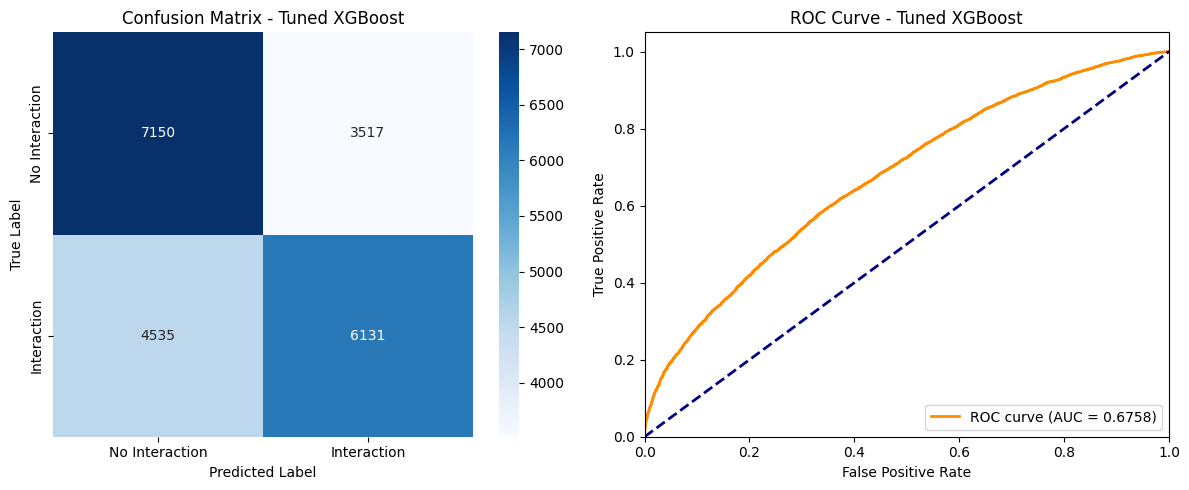


Detailed Classification Report:
                precision    recall  f1-score   support

No Interaction       0.61      0.67      0.64     10667
   Interaction       0.64      0.57      0.60     10666

      accuracy                           0.62     21333
     macro avg       0.62      0.62      0.62     21333
  weighted avg       0.62      0.62      0.62     21333



In [12]:
# Create confusion matrix
cm = confusion_matrix(y_val, y_val_pred_tuned)

# Plot confusion matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Interaction', 'Interaction'],
            yticklabels=['No Interaction', 'Interaction'])
plt.title('Confusion Matrix - Tuned XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Plot ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba_tuned)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned XGBoost')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_val_pred_tuned, 
                          target_names=['No Interaction', 'Interaction']))

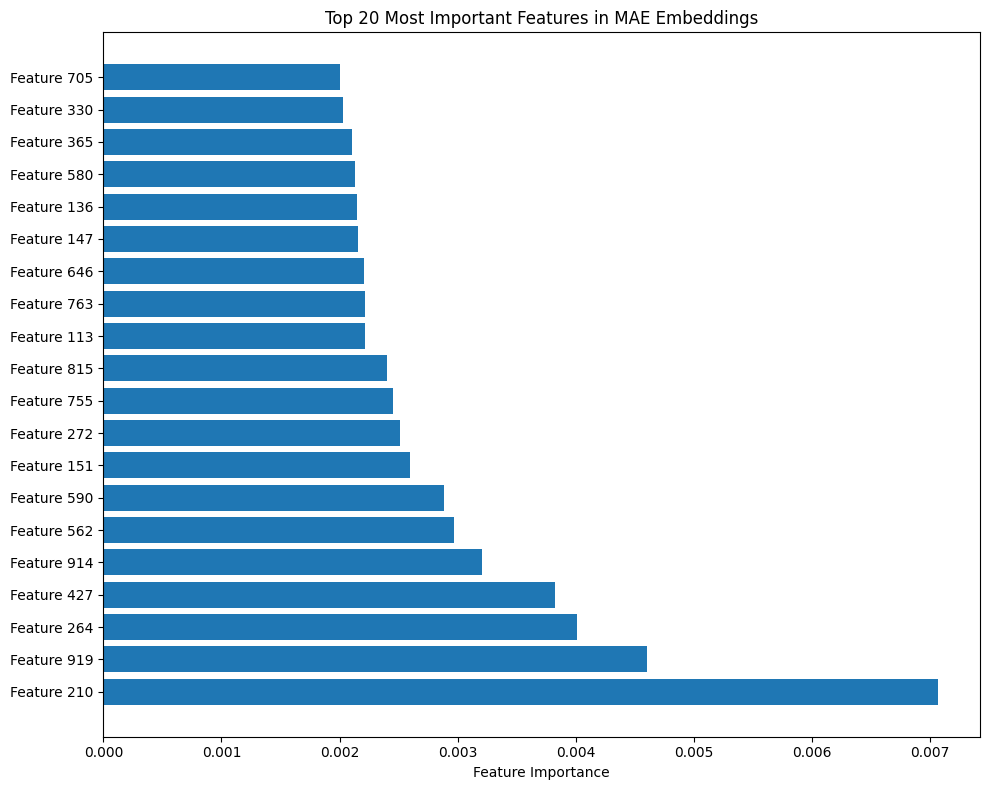

Top 20 most important feature indices:
[210 919 264 427 914 562 590 151 272 755 815 113 763 646 147 136 580 365
 330 705]
Their importance scores:
[0.00706922 0.00460195 0.00401196 0.00382276 0.00320578 0.00296975
 0.00288694 0.00259759 0.00251396 0.00245544 0.0024006  0.00221911
 0.00221201 0.0022088  0.00215589 0.00215092 0.00213215 0.00210454
 0.0020252  0.00200198]


In [13]:
# Get feature importance from the best model
feature_importance = best_xgb_model.feature_importances_

# Since we have 960-dimensional embeddings, let's look at top features
n_top_features = 20
top_indices = np.argsort(feature_importance)[-n_top_features:]
top_importance = feature_importance[top_indices]

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(n_top_features), top_importance[::-1])
plt.yticks(range(n_top_features), [f'Feature {i}' for i in top_indices[::-1]])
plt.xlabel('Feature Importance')
plt.title(f'Top {n_top_features} Most Important Features in MAE Embeddings')
plt.tight_layout()
plt.show()

print(f"Top {n_top_features} most important feature indices:")
print(top_indices[::-1])
print(f"Their importance scores:")
print(top_importance[::-1])

In [14]:
# Save the best XGBoost model
model_output_path = 'experiments/v3/best_xgboost_mae_model.pkl'
with open(model_output_path, 'wb') as f:
    pickle.dump(best_xgb_model, f)
print(f"Best XGBoost model saved to {model_output_path}")

# Make predictions on test sets
print("\nMaking predictions on test sets...")

test1_data = pickle.load(open('data/full_dataset/pair_embeddings/test1_data_with_mae_embeddings.pkl', 'rb'))
test2_data = pickle.load(open('data/full_dataset/pair_embeddings/test2_data_with_mae_embeddings.pkl', 'rb'))

test1_embeddings = test1_data['embeddings']
test2_embeddings = test2_data['embeddings']
test1_interactions = test1_data['interactions']
test2_interactions = test2_data['interactions']

# Test set 1
X_test1 = test1_embeddings
y_test1 = test1_interactions

y_test1_pred = best_xgb_model.predict(X_test1)
y_test1_proba = best_xgb_model.predict_proba(X_test1)[:, 1]

test1_accuracy = accuracy_score(y_test1, y_test1_pred)
test1_f1 = f1_score(y_test1, y_test1_pred)
test1_auc = roc_auc_score(y_test1, y_test1_proba)

print(f"Test Set 1 Results:")
print(f"Accuracy: {test1_accuracy:.4f}")
print(f"F1 Score: {test1_f1:.4f}")
print(f"AUC: {test1_auc:.4f}")

# Test set 2
X_test2 = test2_embeddings
y_test2 = test2_interactions

y_test2_pred = best_xgb_model.predict(X_test2)
y_test2_proba = best_xgb_model.predict_proba(X_test2)[:, 1]

test2_accuracy = accuracy_score(y_test2, y_test2_pred)
test2_f1 = f1_score(y_test2, y_test2_pred)
test2_auc = roc_auc_score(y_test2, y_test2_proba)

print(f"\nTest Set 2 Results:")
print(f"Accuracy: {test2_accuracy:.4f}")
print(f"F1 Score: {test2_f1:.4f}")
print(f"AUC: {test2_auc:.4f}")

# Summary of all results
print(f"\n{'='*50}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*50}")
print(f"Validation Set - Accuracy: {accuracy_tuned:.4f}, F1: {f1_tuned:.4f}, AUC: {auc_tuned:.4f}")
print(f"Test Set 1     - Accuracy: {test1_accuracy:.4f}, F1: {test1_f1:.4f}, AUC: {test1_auc:.4f}")
print(f"Test Set 2     - Accuracy: {test2_accuracy:.4f}, F1: {test2_f1:.4f}, AUC: {test2_auc:.4f}")

Best XGBoost model saved to experiments/v3/best_xgboost_mae_model.pkl

Making predictions on test sets...
Test Set 1 Results:
Accuracy: 0.5082
F1 Score: 0.3833
AUC: 0.5121

Test Set 2 Results:
Accuracy: 0.6865
F1 Score: 0.1518
AUC: 0.5241

FINAL RESULTS SUMMARY
Validation Set - Accuracy: 0.6226, F1: 0.6036, AUC: 0.6758
Test Set 1     - Accuracy: 0.5082, F1: 0.3833, AUC: 0.5121
Test Set 2     - Accuracy: 0.6865, F1: 0.1518, AUC: 0.5241
